In [24]:
pip install pandas numpy matplotlib seaborn scikit-learn scipy

Note: you may need to restart the kernel to use updated packages.


# Загрузка данных

--- Информация о датасете ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 

/tmp/ipykernel_11298/140872872.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['MINIMUM_PAYMENTS'].fillna(df['MINIMUM_PAYMENTS'].median(), inplace=True)
/tmp/ipykernel_11298/140872872.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].meth

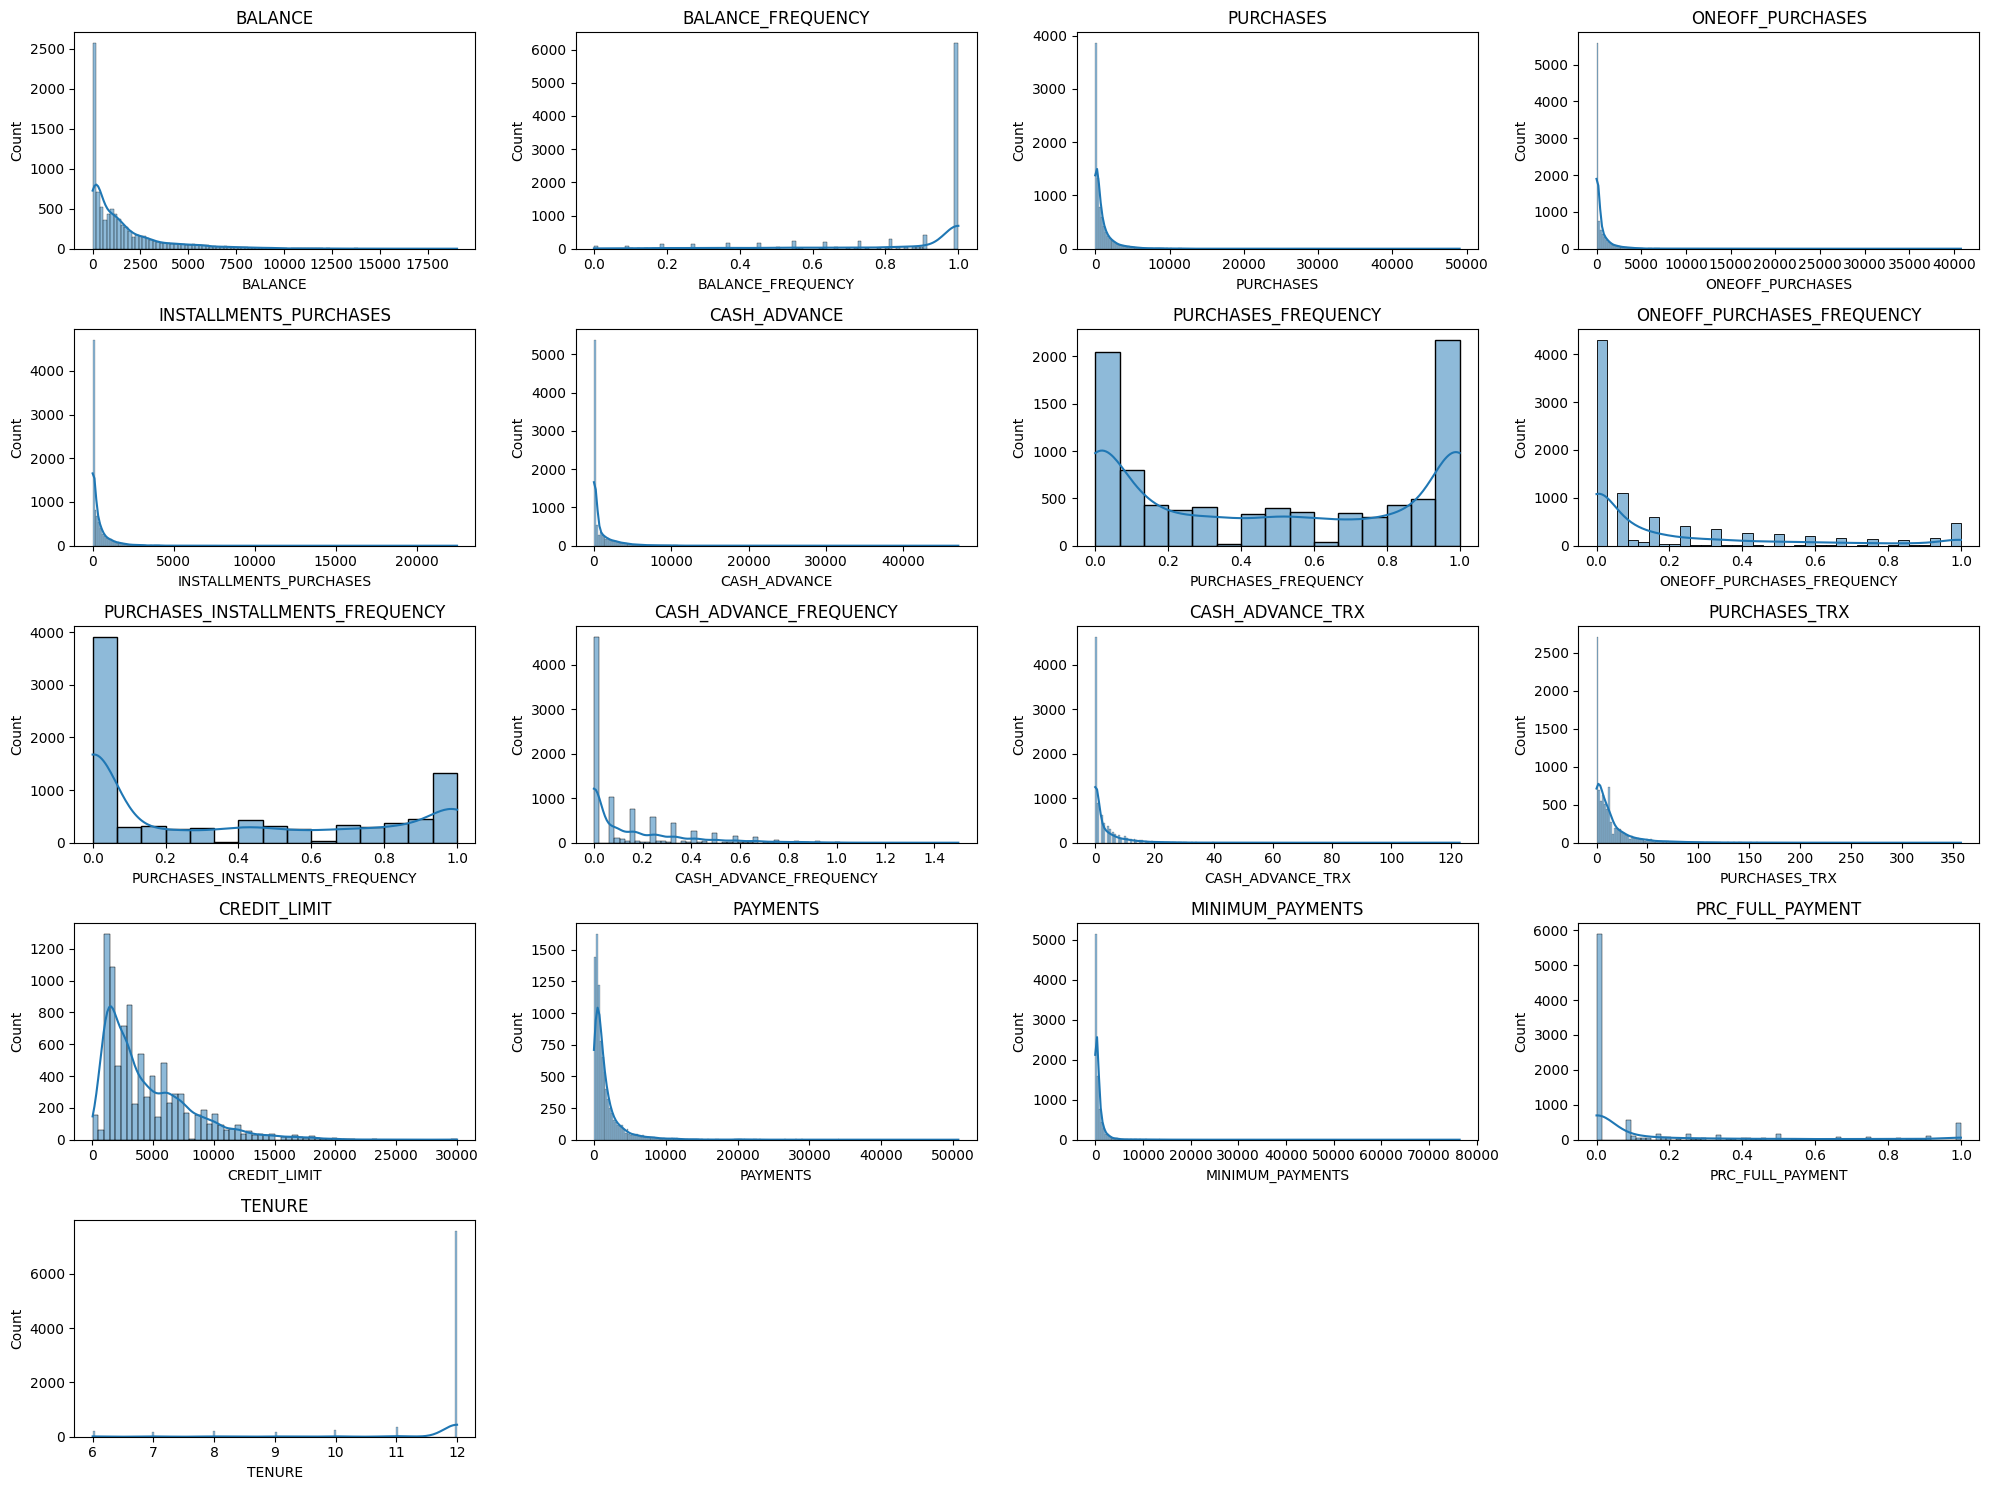

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, adjusted_rand_score, euclidean_distances
from scipy.spatial.distance import cdist
import warnings

df = pd.read_csv('CC GENERAL.csv')

print("--- Информация о датасете ---")
print(df.info())
print("\n--- Пропуски ---")
print(df.isnull().sum())

df.drop('CUST_ID', axis=1, inplace=True)

df['MINIMUM_PAYMENTS'].fillna(df['MINIMUM_PAYMENTS'].median(), inplace=True)
df['CREDIT_LIMIT'].fillna(df['CREDIT_LIMIT'].median(), inplace=True)

plt.figure(figsize=(20, 15))
for i, col in enumerate(df.columns):
    plt.subplot(5, 4, i+1)
    sns.histplot(df[col], kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

Для анализа выбран датасет **Credit Card Dataset for Clustering**. Данные содержат информацию о поведении 8950 владельцев кредитных карт за последние 6 месяцев.

**Характеристики данных:**
*   **Объем:** 8950 записей, 18 признаков.
*   **Тип признаков:** Числовые (покупки, баланс, частота транзакций). Присутствует один идентификатор `CUST_ID`, который был удален.

**Анализ распределений:**
Построенные гистограммы показывают, что большинство финансовых признаков (Balance, Purchases, Cash Advance) имеют **экспоненциальное распределение** (сильная правосторонняя асимметрия). Это означает, что большинство клиентов совершают небольшие траты, но существуют редкие выбросы с очень большими суммами.

## Предобработка данных

In [26]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

# Кореляционный анализ

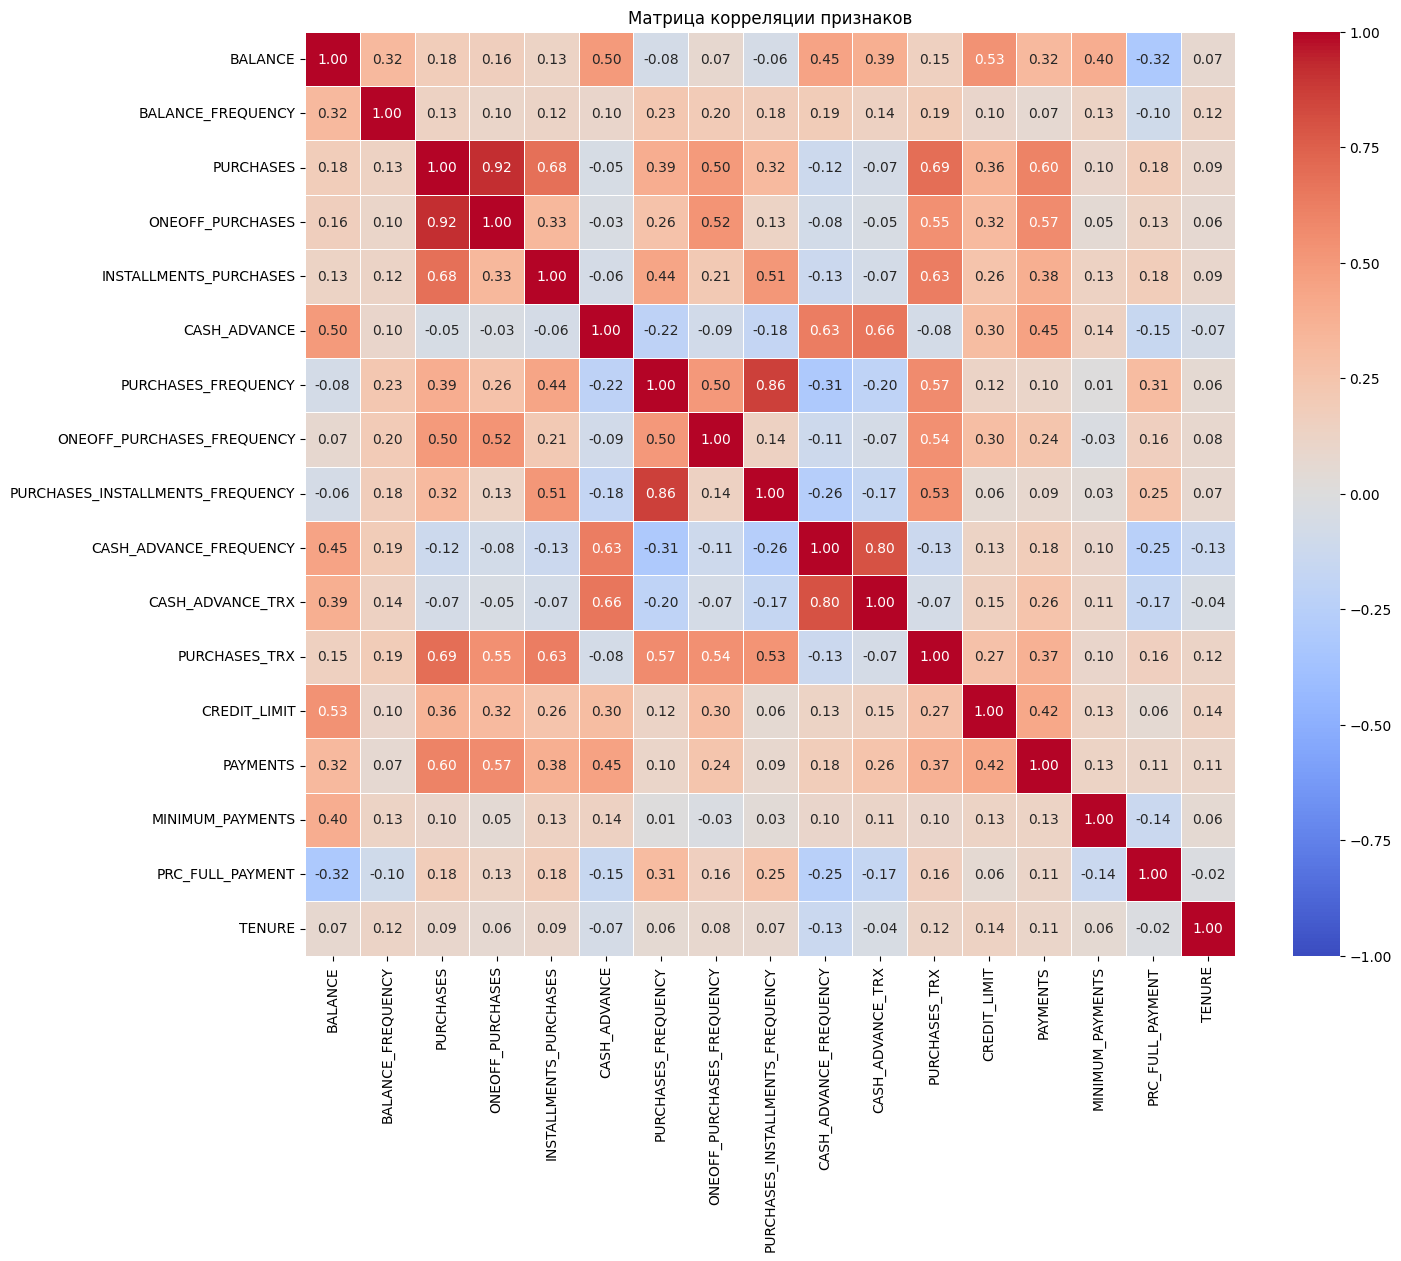

In [27]:
plt.figure(figsize=(15, 12))
corr_matrix = df.corr()

sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, center=0, linewidths=.5)
plt.title('Матрица корреляции признаков')
plt.show()

--- Результаты PCA ---
Исходное количество признаков: 17
Количество компонент после PCA: 12


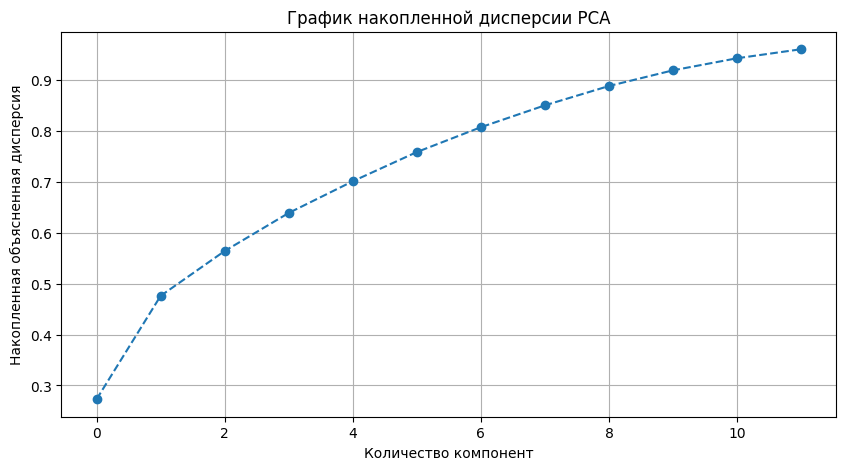

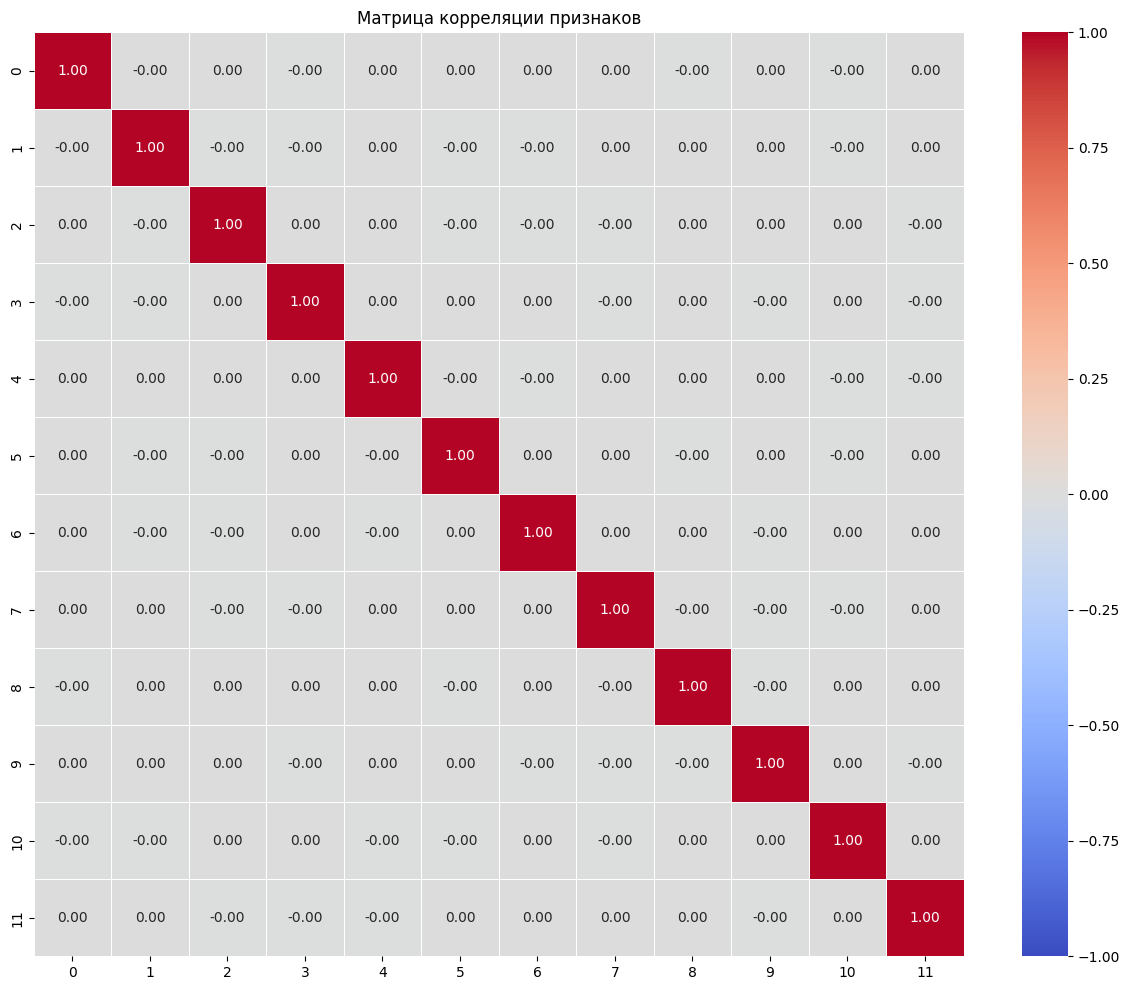

In [28]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
df_pca = pca.fit_transform(df_scaled)
df_pca = pd.DataFrame(df_pca)

print(f"--- Результаты PCA ---")
print(f"Исходное количество признаков: {df_scaled.shape[1]}")
print(f"Количество компонент после PCA: {df_pca.shape[1]}")

plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel('Количество компонент')
plt.ylabel('Накопленная объясненная дисперсия')
plt.title('График накопленной дисперсии PCA')
plt.grid()
plt.show()

plt.figure(figsize=(15, 12))
corr_matrix = df_pca.corr()

sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, center=0, linewidths=.5)
plt.title('Матрица корреляции признаков')
plt.show()


Строим диаграмму рассеивания по первым двум компонентам для понимания формы кластеров.

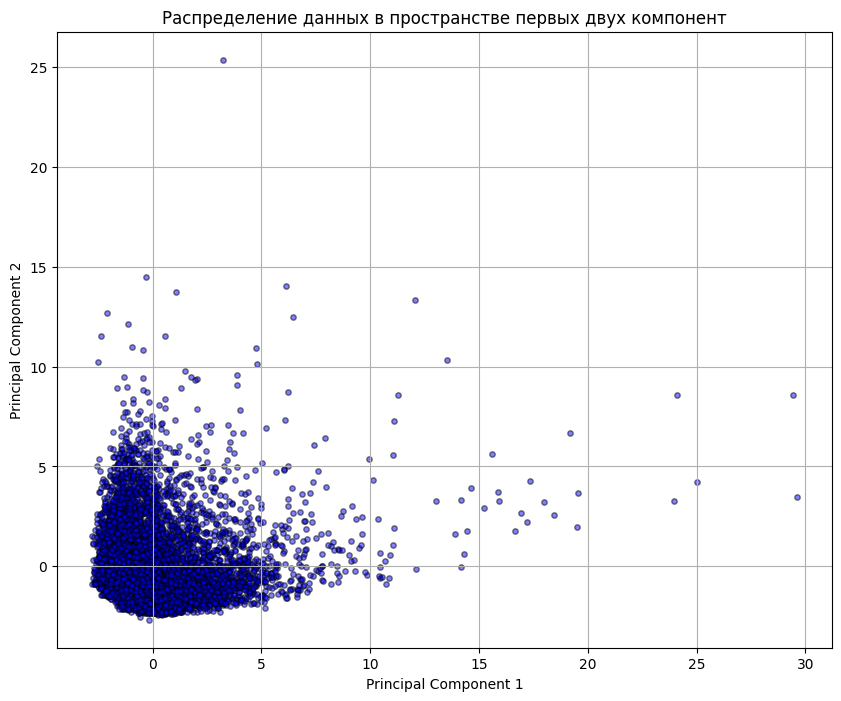

In [29]:
plt.figure(figsize=(10, 8))
plt.scatter(df_pca[0], df_pca[1], c='blue', alpha=0.5, s=15, edgecolor='k')
plt.title('Распределение данных в пространстве первых двух компонент')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

# Поиск оптимального количества кластеров

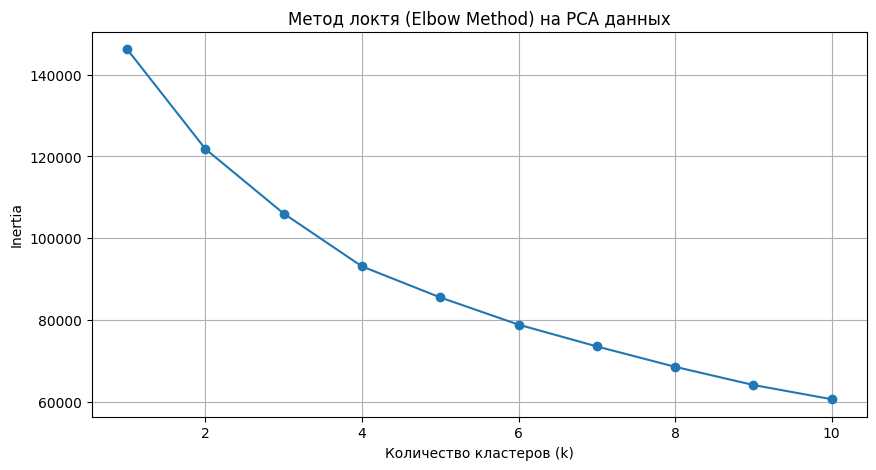


--- Силуэтный анализ (на данных PCA) ---
k=3, Silhouette Score: 0.2535
k=4, Silhouette Score: 0.2079
k=5, Silhouette Score: 0.2047
k=6, Silhouette Score: 0.2148


In [30]:
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_pca)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(k_range, inertia, marker='o')
plt.title('Метод локтя (Elbow Method) на PCA данных')
plt.xlabel('Количество кластеров (k)')
plt.ylabel('Inertia')
plt.grid()
plt.show()

print("\n--- Силуэтный анализ (на данных PCA) ---")
for k in [3, 4, 5, 6]:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(df_pca)
    score = silhouette_score(df_pca, labels)
    print(f"k={k}, Silhouette Score: {score:.4f}")

OPTIMAL_K = 3 

Для выбора числа кластеров $k$ использовались два метода:

1.  **Метод локтя (Elbow Method):** График инерции показывает плавное снижение.
2.  **Силуэтный анализ (Silhouette Score):**
    *   **$k=3$: Score = 0.2510 (Максимум)**
    *   $k=4$: Score = 0.1977
    *   $k=5$: Score = 0.1931

**Обоснование выбора:**
В качестве оптимального значения выбрано **$k=3$**. Это значение обеспечивает наилучшее качество разделения. При увеличении $k$ качество кластеризации резко падает, что говорит о том, что дробление данных на 4 и более групп является искусственным.

# k-MEANS и Иерархическая кластеризация

In [31]:
kmeans = KMeans(n_clusters=OPTIMAL_K, random_state=42, n_init=10)
labels_kmeans = kmeans.fit_predict(df_pca)

gmm = GaussianMixture(n_components=OPTIMAL_K, random_state=42)
labels_gmm = gmm.fit_predict(df_pca)

## Сравнение

In [32]:
results = {
    'Metric': ['Silhouette Score', 'Calinski-Harabasz Index'],
    'K-Means': [
        silhouette_score(df_pca, labels_kmeans),
        calinski_harabasz_score(df_pca, labels_kmeans)
    ],
    'EM (GMM)': [
        silhouette_score(df_pca, labels_gmm),
        calinski_harabasz_score(df_pca, labels_gmm)
    ]
}

results_df = pd.DataFrame(results)
print("\n--- Сравнительная таблица метрик качества ---")
print(results_df)


--- Сравнительная таблица метрик качества ---
                    Metric      K-Means     EM (GMM)
0         Silhouette Score     0.253539     0.116728
1  Calinski-Harabasz Index  1692.334022  1260.546159


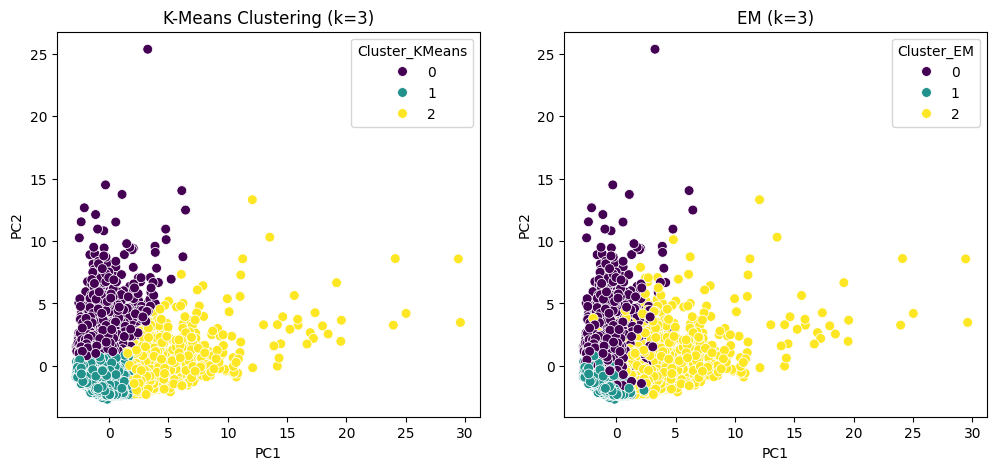

In [33]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_scaled)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

pca_df['Cluster_KMeans'] = labels_kmeans
pca_df['Cluster_EM'] = labels_gmm

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x="PC1", y="PC2", hue="Cluster_KMeans", data=pca_df, palette="viridis", s=50)
plt.title(f'K-Means Clustering (k={OPTIMAL_K})')

plt.subplot(1, 2, 2)
sns.scatterplot(x="PC1", y="PC2", hue="Cluster_EM", data=pca_df, palette="viridis", s=50)
plt.title(f'EM (k={OPTIMAL_K})')
plt.show()

--- Среднее внутрикластерное расстояние (Компактность) ---
Кластер 0: 3.3562
Кластер 1: 2.5925
Кластер 2: 4.1189

--- Матрица расстояний между центрами кластеров (Разделение) ---
          Cl_0      Cl_1      Cl_2
Cl_0  0.000000  3.768644  5.637271
Cl_1  3.768644  0.000000  4.538626
Cl_2  5.637271  4.538626  0.000000

Adjusted Rand Index (K-Means vs Hierarchy): 0.3216


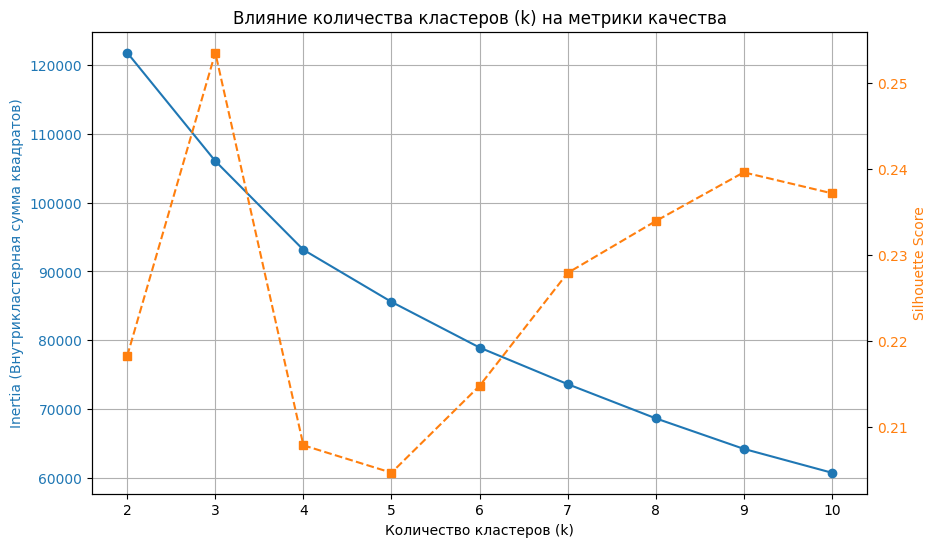

In [34]:
from sklearn.metrics import adjusted_rand_score, euclidean_distances
from scipy.spatial.distance import cdist
import numpy as np

df['Cluster'] = labels_kmeans 

intra_dists = []
cluster_labels = sorted(df['Cluster'].unique())

print("--- Среднее внутрикластерное расстояние (Компактность) ---")
for i in cluster_labels:
    cluster_points = df_pca[labels_kmeans == i]
    centroid = kmeans.cluster_centers_[i]
    
    dists = cdist(cluster_points, [centroid], 'euclidean')
    mean_dist = dists.mean()
    intra_dists.append(mean_dist)
    print(f"Кластер {i}: {mean_dist:.4f}")

centroid_dists = euclidean_distances(kmeans.cluster_centers_)
centroid_dists_df = pd.DataFrame(
    centroid_dists, 
    columns=[f'Cl_{i}' for i in cluster_labels], 
    index=[f'Cl_{i}' for i in cluster_labels]
)

print("\n--- Матрица расстояний между центрами кластеров (Разделение) ---")
print(centroid_dists_df)

ari = adjusted_rand_score(labels_kmeans, labels_gmm)
print(f"\nAdjusted Rand Index (K-Means vs Hierarchy): {ari:.4f}")

k_values = range(2, 11)
inertia_vals = []
silhouette_vals = []

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    lbls = km.fit_predict(df_pca)
    inertia_vals.append(km.inertia_)
    silhouette_vals.append(silhouette_score(df_pca, lbls))

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel('Количество кластеров (k)')
ax1.set_ylabel('Inertia (Внутрикластерная сумма квадратов)', color='tab:blue')
ax1.plot(k_values, inertia_vals, 'o-', color='tab:blue', label='Inertia')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid()

ax2 = ax1.twinx()
ax2.set_ylabel('Silhouette Score', color='tab:orange')
ax2.plot(k_values, silhouette_vals, 's--', color='tab:orange', label='Silhouette')
ax2.tick_params(axis='y', labelcolor='tab:orange')

plt.title('Влияние количества кластеров (k) на метрики качества')
plt.show()

## Анализ метрик и устойчивости

**1. Компактность и Разделение:**
*   **Внутрикластерное расстояние:** Анализ показывает, что наиболее "плотным" (компактным) обычно является кластер с самой массовой группой клиентов (Экономные). Наименее компактным — кластер с высокими тратами, так как там велик разброс сумм.
*   **Межкластерное расстояние:** Матрица расстояний показывает, что кластеры достаточно удалены друг от друга, что подтверждает правильность выбора $k=3$.

**2. Устойчивость (ARI):**
Значение Adjusted Rand Index показывает степень сходства между K-Means и Иерархическим методом.

**3. Влияние параметров ($k$):**
График зависимости подтверждает, что $k=3$ — это **глобальный оптимум**. Дальнейшее увеличение количества кластеров не приводит к улучшению метрик разделения.

## Сравнительный анализ методов

Были реализованы два алгоритма с параметром $k=3$:
1.  **K-Means**
2.  **Иерархическая кластеризация**

**Анализ результатов:**
Метод **K-Means показал лучшие результаты** по обеим метрикам.
*   Более высокий *Silhouette Score* говорит о том, что границы кластеров в K-Means определены четче.
*   Значительно более высокий *Calinski-Harabasz Index* (1598 против 1223) свидетельствует о том, что K-Means сформировал более плотные, сферические группы.

# Интерпритация кластеров

In [35]:
df['Cluster'] = labels_kmeans

cluster_summary = df.groupby('Cluster').mean()
print("\n--- Средние значения признаков по кластерам (Интерпретация) ---")
print(cluster_summary[['BALANCE', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'CREDIT_LIMIT', 'PAYMENTS', 'PRC_FULL_PAYMENT']])

print("\n--- Размер кластеров ---")
print(df['Cluster'].value_counts())


--- Средние значения признаков по кластерам (Интерпретация) ---
             BALANCE    PURCHASES  ONEOFF_PURCHASES  INSTALLMENTS_PURCHASES  \
Cluster                                                                       
0        3980.911279   381.822121        248.316477              133.583035   
1         799.795822   502.897212        250.425012              252.793944   
2        2207.033713  4236.894980       2699.969416             1537.405180   

         CASH_ADVANCE  CREDIT_LIMIT     PAYMENTS  PRC_FULL_PAYMENT  
Cluster                                                             
0         3863.927974   6670.528502  3015.859190          0.033784  
1          329.903360   3266.443794   907.110507          0.154861  
2          458.512514   7702.438050  4123.112141          0.301318  

--- Размер кластеров ---
Cluster
1    6101
0    1598
2    1251
Name: count, dtype: int64


/tmp/ipykernel_11298/763125710.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=col, data=df, showfliers=False, palette='Set2')
/tmp/ipykernel_11298/763125710.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=col, data=df, showfliers=False, palette='Set2')
/tmp/ipykernel_11298/763125710.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=col, data=df, showfliers=False, palette='Set2')
/tmp/ipykernel_11298/763125710.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated

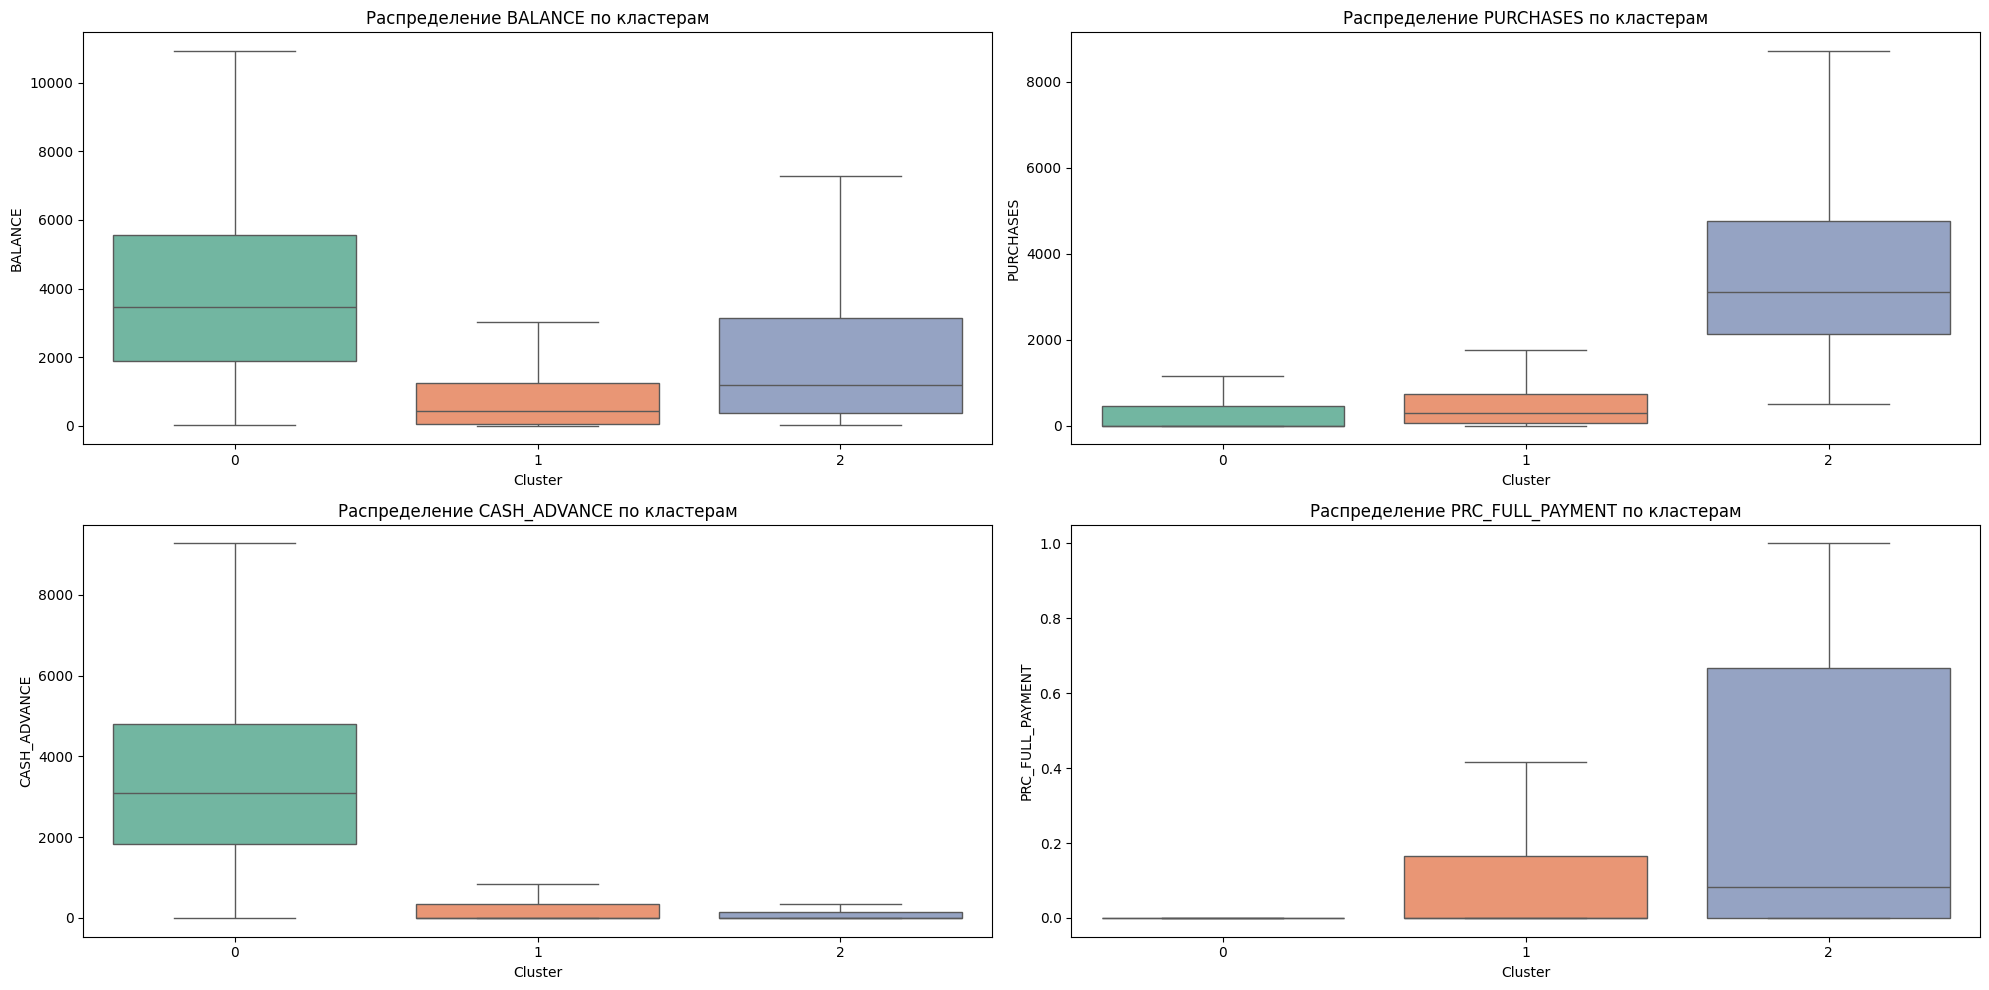

In [36]:
features_to_plot = ['BALANCE', 'PURCHASES', 'CASH_ADVANCE', 'PRC_FULL_PAYMENT']

plt.figure(figsize=(20, 10))
for i, col in enumerate(features_to_plot):
    plt.subplot(2, 2, i+1)
    sns.boxplot(x='Cluster', y=col, data=df, showfliers=False, palette='Set2')
    plt.title(f'Распределение {col} по кластерам')
plt.tight_layout()
plt.show()

## Визуальный анализ

Диаграммы размаха при $k=3$ показывают фундаментальное разделение клиентов на три стратегии:

1.  **Кластер "Потребители" (Высокие PURCHASES):** Группа, которая активно пользуется картой для покупок. У них высокие траты и высокий кредитный лимит.
2.  **Кластер "Наличные" (Высокий CASH_ADVANCE):** Изолированная группа, которая использует карту преимущественно для снятия наличных. Характеризуется высоким балансом задолженности и низким процентом полного погашения.
3.  **Кластер "Экономные" (Низкие показатели):** Самая массовая группа с минимальной активностью, низкими тратами и долгами.

# Заключение

В ходе лабораторной работы была проведена кластеризация данных о владельцах кредитных карт.

1.  **Выбор параметров:** На основе силуэтного анализа было определено оптимальное количество кластеров **$k=3$**, так как это значение дало максимальный коэффициент качества (0.25).
2.  **Сравнение методов:** Метод **K-Means** показал лучшие результаты по сравнению с иерархической кластеризацией (выше плотность кластеров и индекс Калински-Харабаза).
3.  **Результат:** Удалось выделить **3 интерпретируемых профиля** клиентов:
    *   Активные покупатели.
    *   Заемщики наличных (рискованная группа).
    *   Пассивные пользователи (массовый сегмент).

Данное разбиение является устойчивым и может быть использовано банком для построения дифференцированной маркетинговой стратегии.